In [122]:
import pandas as pd
import numpy as np
import json 
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import CategoricalDtype 
import matplotlib.ticker as ticker
import math

from sklearn import tree, model_selection, metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV

In [132]:
df = pd.read_csv("Output/Combined_dataset.csv")
df = df.drop('Unnamed: 0', axis=1)
print(df.shape)

(1000, 32)


In [133]:
# Drop Duplicates
df = df.drop_duplicates('id', keep ='first')
print(df.shape)

(985, 32)


In [134]:
# Convert numerical cols type to int/float
df['duration'] = pd.to_numeric(pd.to_timedelta(df['duration']).dt.days, downcast='integer')
df['num_faq'] = df['num_faq'].astype(int)
df['n_comments'] = df['n_comments'].str.replace(',', '').astype(float)

# Convert rows from str to dict
def string_to_dict(dict_string):
    # Convert to proper json format
    dict_string = dict_string.replace("'", "'").replace('u"', '"')
    return json.loads(dict_string)

df.category = df.category.apply(string_to_dict)

# Get category values from dictionary
df['parent_category'] = [d.get('parent_name') for d in df.category]
df['category_name'] = [d.get('name') for d in df.category]
df["parent_category"].fillna("No Parent Category", inplace = True)

# Get Location of Projects from location dict
def get_location(i):
    i = str(i).replace('nan', '{"name": ""}')
    i = i.replace('false', 'False')
    i = i.replace('null', '{"name": ""}')
    name_i = eval(i).get('name')
    if len(name_i) == 0:
        return None
    else:
        if name_i.isdigit():
            return None
        else:
            return name_i
    
df['location_name'] = df.location.apply(lambda x: get_location(x))
df["location_name"].fillna("None", inplace = True)

In [135]:
# Fill na for text cols
df["story"].fillna(" ", inplace = True)

# Clean up comments 
df['comments'] = df['comments'].apply(lambda x: x.replace('Only backers can post comments. Log in\n',""))

print(df.shape)
df.sample(3)

(985, 35)


,backers_count,blurb,category,converted_pledged_amount,country,created_at,current_currency,deadline,fx_rate,goal,...,usd_type,story,faq,num_faq,comments,n_comments,duration,parent_category,category_name,location_name
98,2343,"Thunderbird is changing, and add-ons must chan...","{'id': 51, 'name': 'Software', 'slug': 'techno...",51841,US,2020-01-01 12:29,USD,2020-03-30 10:52,1.000000,50000,...,domestic,"(English speakers, please read on below this p...",[' Can I support you and get one of the reward...,5,"Sanier Armand\nabout 6 hours ago\nHello, nice ...",119.0,67,Technology,Software,Boston
867,8,After recently creating a one-off vest for mys...,"{'id': 263, 'name': 'Apparel', 'slug': 'fashio...",264,GB,2015-02-23 15:19,USD,2015-03-25 15:35,1.384815,150,...,international,I wanted to use the artwork from my EP Strix o...,[' '],0,No comments yet.,0.0,30,Fashion,Apparel,Taunton
378,8,I've just been accepted to my first gallery sh...,"{'id': 20, 'name': 'Conceptual Art', 'slug': '...",620,US,2011-03-15 23:09,USD,2011-03-23 23:33,1.000000,500,...,international,My name is Travis Williams. I am an art studen...,[' '],0,No comments yet.,0.0,8,Art,Conceptual Art,Kansas City


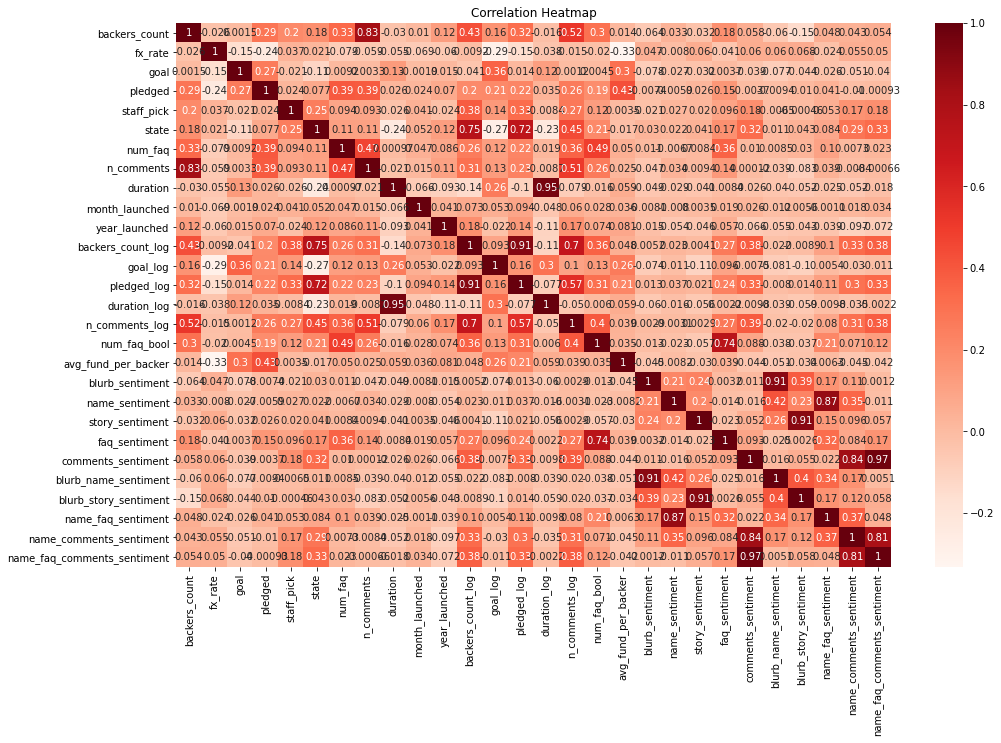

In [219]:
# Correlation heatmap
plt.figure(figsize=(16,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds).set_title("Correlation Heatmap")

plt.show()

# Feature Engineering

In [137]:
categorical_cols = ['country', 'staff_pick', 'usd_type', 'parent_category', 'category_name', 'location_name']
num_cols = ['backers_count', 'fx_rate', 'goal', 'pledged', 'num_faq', 'n_comments', 'duration']
text_cols = ['blurb', 'name', 'story', 'faq', 'comments']

In [138]:
#Change state to binary (1 = success project, 0 = failed project)
df.state = df.state.astype('category').cat.codes

In [139]:
# Get month/year of launch/deadline
df['month_launched'] = pd.DatetimeIndex(df['launched_at']).month.astype(int)
df['year_launched'] = pd.DatetimeIndex(df['launched_at']).year.astype(int)

num_cols.append('month_launched')
num_cols.append('year_launched')

In [140]:
# Log Transformation
boxplot_features = ['backers_count', 'goal', 'pledged', 'duration', 'n_comments']

for feature in boxplot_features:
    new_col = feature + '_log'
    df[new_col] = df[feature].apply(lambda x: math.log(x+1))
    df[new_col] = (df[new_col] - df[new_col].mean())/df[new_col].std()

In [141]:
# Boolean Transformation
df['num_faq_bool'] = df['num_faq'].apply(lambda x: np.where(x >0, 1, 0))

In [160]:
# Average fund per backer
df['avg_fund_per_backer'] = df['pledged']/df['backers_count']
df["avg_fund_per_backer"].fillna(0, inplace = True)
num_cols.append('avg_fund_per_backer')

# Text Preprocessing & Analysis

In [143]:
# Extra text features to be analyzed by combining pre-existing text features
df['blurb_name'] = df['blurb'] + df['name']
df['blurb_story'] = df['blurb'] + df['story']
df['name_faq'] = df['name'] + df['faq']
df['name_comments'] = df['name'] + df['comments']
df['name_faq_comments'] = df['faq'] + df['comments']

text_cols2 = ['blurb_name', 'blurb_story', 'name_faq', 'name_comments', 'name_faq_comments']
text_cols = text_cols + text_cols2

In [144]:
# Text Analysis
from textblob import TextBlob

# define a function that accepts text and returns the polarity
def detect_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

# create a new DataFrame column for sentiment 
for col in text_cols:
    col_name = col + '_sentiment'
    df[col_name] = df[col].apply(detect_sentiment)
    
df = df.drop(text_cols, axis=1)
df.head(3)

,backers_count,category,converted_pledged_amount,country,created_at,current_currency,deadline,fx_rate,goal,id,...,blurb_sentiment,name_sentiment,story_sentiment,faq_sentiment,comments_sentiment,blurb_name_sentiment,blurb_story_sentiment,name_faq_sentiment,name_comments_sentiment,name_faq_comments_sentiment
0,1,"{'id': 331, 'name': '3D Printing', 'slug': 'te...",1,ES,2015-08-18 21:01,USD,2016-07-09 20:11,1.212886,15000,1662798399,...,0.0,0.0,0.160156,0.0,0.0,0.000000,0.160156,0.0,0.0,0.0
1,2,"{'id': 309, 'name': 'Farms', 'slug': 'food/far...",9,NZ,2015-08-11 18:04,USD,2015-09-11 15:55,0.723585,5000,1316288919,...,0.2,0.4,0.357143,0.0,0.0,0.266667,0.322222,0.4,0.4,0.0
2,0,"{'id': 54, 'name': 'Mixed Media', 'slug': 'art...",0,US,2015-04-28 21:14,USD,2015-05-28 21:14,1.000000,10000,818890122,...,0.5,0.5,0.143182,0.0,0.0,0.500000,0.158696,0.5,0.5,0.0


# Train Test Split

In [162]:
# Cols to drop

#pledge, usd_pledge and converted_pledged_amt basically is the same thing, keep pledge col only
#Country and location basically the same, keep country
#Not meaningful cols: profile, created at, deadline, id, launched_at, source url, state chnaged at, urls, static usd rate
#drop category (extracted parent cat and cat name)
#name and slug basicially the same (drop slug)

cols_to_drop = ['profile', 'category', 'created_at', 'location', 'current_currency', 'deadline', 'id', 
                'launched_at', 'slug', 'source_url', 'state_changed_at', 'urls', 'static_usd_rate', 
                'usd_pledged', 'converted_pledged_amount', 'spotlight']
df = df.drop(cols_to_drop, axis=1)

KeyError: "['profile' 'category' 'created_at' 'location' 'current_currency'\n 'deadline' 'id' 'launched_at' 'slug' 'source_url' 'state_changed_at'\n 'urls' 'static_usd_rate' 'usd_pledged' 'converted_pledged_amount'\n 'spotlight'] not found in axis"

In [265]:
# Split dataset
X = df.drop('state', axis=1)
y = df.state

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=2019)

In [266]:
# One Hot Encoding with training set only
OHE_df = pd.DataFrame()

for i in categorical_cols:
    OHE_df[i] = X_train[i].astype(CategoricalDtype(list(set(X[i]))))
    
    OHE_df = pd.concat([OHE_df, pd.get_dummies(X[i], prefix=i)],axis=1)

In [267]:
OHE_df = OHE_df.drop(categorical_cols, axis= 1)

X_no_cat = X.drop(categorical_cols, axis= 1)
OHE_df = pd.concat([X_no_cat, OHE_df],axis=1)

# For Decision Tree
OHE_df = OHE_df.drop(OHE_df.loc[:, OHE_df.columns.str.contains('_log')].columns.tolist(), axis=1)

In [268]:
OHE_train, OHE_test, y_train, y_test = model_selection.train_test_split(OHE_df, y, test_size=0.2, random_state=2019)

## ?? 

In [25]:

# int_cols = ['backers_count', 'num_faq', 'n_comments', 'duration', 'month_launched', 'year_launched']
# OHE_df[num_cols] = OHE_df[num_cols].apply(lambda x: x.astype('int')) 

# categorical_cols2 = []
# for i in categorical_cols:
#     categorical_cols2 += [col for col in OHE_df.columns if i in col]
    
# OHE_df[categorical_cols2] = OHE_df[categorical_cols2].apply(lambda x: x.astype('category')) 

In [ ]:
# # apply OneHotEncoder on categorical feature columns
# ohe = OneHotEncoder(handle_unknown = 'ignore') 

# X_train_ohe = ohe.fit_transform(X_train[categorical_cols]) 
# X_test_ohe = ohe.transform(X_test[categorical_cols])

# OHE_train = np.hstack((X_train.drop(categorical_cols, axis=1).values, X_train_ohe.toarray()))
# OHE_test = np.hstack((X_test.drop(categorical_cols, axis=1).values, X_test_ohe.toarray()))

### Text Analysis

In [ ]:
# # Term Frequency (count the number of occurrences of each term in each document)
# # TfidfVectorizer (CountVectorizer + TfidfTransformer)
# from sklearn.feature_extraction.text import TfidfVectorizer
# vect = TfidfVectorizer()
# pd.DataFrame(vect.fit_transform(X.comments).toarray(), columns=vect.get_feature_names())

In [ ]:
# from sklearn.naive_bayes import MultinomialNB
# from sklearn import metrics

# # define a function that accepts a vectorizer and calculates the accuracy
# def tokenize_test(vect, col):
    
#     # create document-term matrices using the vectorizer
#     X_train_dtm = vect.fit_transform(X_train[col])
#     X_test_dtm = vect.transform(X_test[col])
    
#     # print the number of features that were generated
#     print('Features: ', X_train_dtm.shape[1])
    
#     # use Multinomial Naive Bayes to predict the star rating
#     nb = MultinomialNB()
#     nb.fit(X_train_dtm, y_train)
#     y_pred_class = nb.predict(X_test_dtm)
    
#     # print the accuracy of its predictions
#     print('Accuracy: ', metrics.accuracy_score(y_test, y_pred_class))

In [ ]:
# # use TfidfVectorizer with default parameters
# vect = TfidfVectorizer()
# tokenize_test(vect, 'comments')

In [ ]:
# # Term Frequency (count the number of occurrences of each term in each document)
# from sklearn.feature_extraction.text import CountVectorizer
# vect = CountVectorizer()
# tokenize_test(vect, 'comments')

In [ ]:
# from afinn import Afinn

# afinn = Afinn(emoticons=True)
# afinn_scores = [afinn.score(text) for text in X.blurb]
# X['afinn_scores'] = afinn_scores
# X[['blurb', 'textblob_sentiment', 'afinn_scores']].head(20)

### DecisionTreeClassifier

In [353]:
from sklearn.tree import DecisionTreeClassifier

# Build Model
dt_estimator = tree.DecisionTreeClassifier(random_state=40)

In [354]:
max_depth = [6,7,8]
min_samples_split = [45,50,55,60,65]
min_samples_leaf = [70,75,80,85]
max_features = [16,27,32,45]

param_grid = {'criterion': ['entropy', 'gini'], 
              'max_depth': max_depth, 
              'min_samples_split': min_samples_split, 
              'min_samples_leaf': min_samples_leaf, 
              'max_features': max_features}

grid_dt_class = GridSearchCV(estimator = dt_estimator, param_grid = param_grid, scoring='accuracy', n_jobs=-1, cv = 10, refit=True, return_train_score=True)

grid_dt_class.fit(OHE_df, y)

print(grid_dt_class.best_params_)
print("Model score: ", grid_dt_class.best_score_)

{'criterion': 'entropy', 'max_depth': 6, 'max_features': 45, 'min_samples_leaf': 75, 'min_samples_split': 45}
Model score:  0.79721706864564


In [358]:
# Evaluate Model 
dtree = DecisionTreeClassifier(criterion= 'entropy', max_depth= 6,
                               max_features= 45, min_samples_leaf= 75,
                               min_samples_split= 45, random_state = 40
                              )
dtree.fit(OHE_train, y_train)
y_predict = dtree.predict(OHE_test)

report = """
The evaluation report is:
Confusion Matrix:
{}
Accuracy: {}
""".format(confusion_matrix(y_test, y_predict),
           accuracy_score(y_test, y_predict))
print(report)


The evaluation report is:
Confusion Matrix:
[[ 64   6]
 [ 23 104]]
Accuracy: 0.8527918781725888



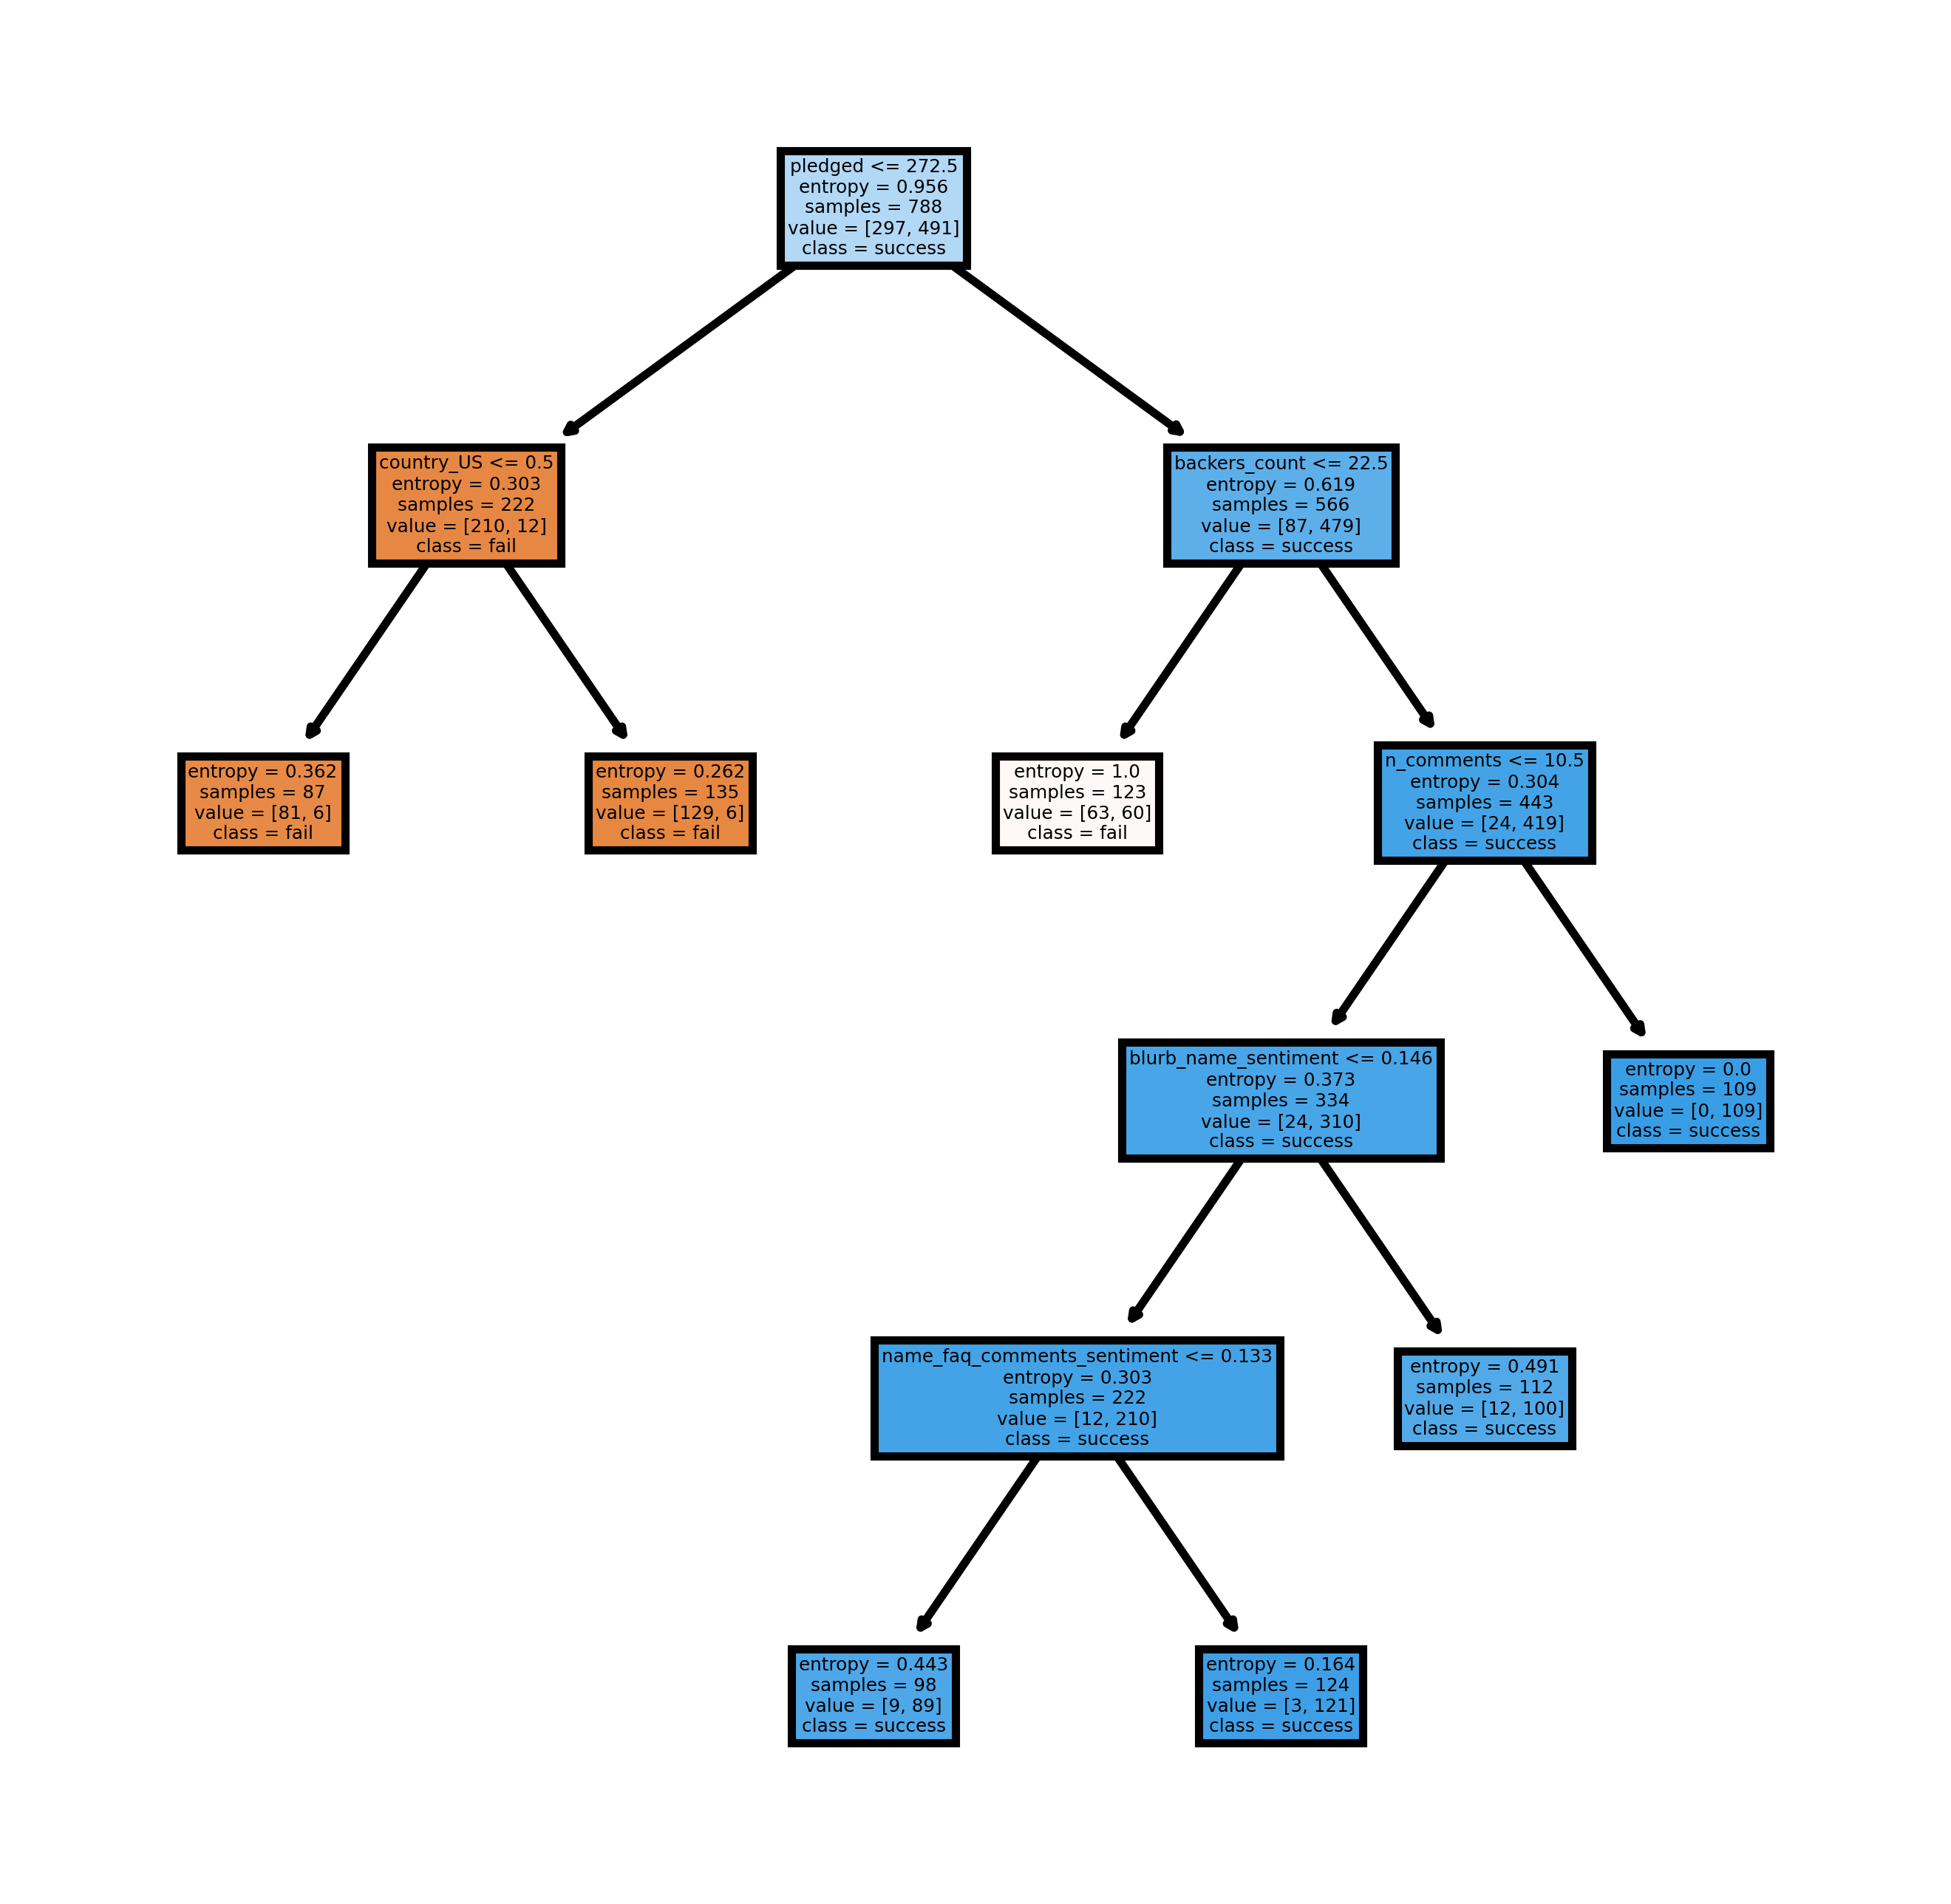

In [359]:
feature_list = list(OHE_train.columns)
cn = ['fail', 'success']

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(dtree,
               feature_names = feature_list, 
               class_names = cn,
               filled = True)
fig.savefig('dtree.png')

In [360]:
# Get Feature Importance
important_features_dict = {}
for idx, val in enumerate(dtree.feature_importances_):
    important_features_dict[idx] = val

top_idx = sorted(important_features_dict,
                                 key=important_features_dict.get,
                                 reverse=True)[:10]

top_features_names = OHE_train.columns[top_idx]
top_features_scores = dtree.feature_importances_[top_idx]

print('Top 3 most important features: \n')

for i in range(3):
    print('%s: %s, Score: %.3f ' % (i+1, top_features_names[i], top_features_scores[i]))


Top 3 most important features: 

1: pledged, Score: 0.755 
2: backers_count, Score: 0.209 
3: n_comments, Score: 0.023 


In [ ]:
# # DT Pruning
# max_depth = []
# acc_gini = []
# acc_entropy = []
# for i in range(1, 10):
#     dtree = DecisionTreeClassifier(criterion='gini', max_depth=i, random_state = 40)
#     dtree.fit(OHE_train, y_train)
#     pred = dtree.predict(OHE_test)
#     acc_gini.append(accuracy_score(y_test, pred))
# ####
#     dtree = DecisionTreeClassifier(criterion='entropy', max_depth=i, random_state = 40)
#     dtree.fit(OHE_train, y_train)
#     pred = dtree.predict(OHE_test)
#     acc_entropy.append(accuracy_score(y_test, pred))
# ####
#     max_depth.append(i)
# d = pd.DataFrame({'acc_gini':pd.Series(acc_gini), 'acc_entropy':pd.Series(acc_entropy),'max_depth':pd.Series(max_depth)})

# # visualizing changes in parameters
# plt.figure(figsize = (20, 7))
# plt.plot('max_depth','acc_gini', data=d, label='gini')
# plt.plot('max_depth','acc_entropy', data=d, label='entropy')
# plt.xticks(np.arange(1, 10, 1))
# plt.xlabel('max_depth')
# plt.ylabel('accuracy')
# plt.legend()